In [23]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import os, sys
main_dir = os.path.abspath('../../')
sys.path.insert(0, main_dir)

import models.helper as hlp
from models.custom.model import *
import forward.fourier.method as fwd
from forward.fourier.kernel_creator import create_fourier_kernel

import gc
def clear_gpu():
    gc.collect()
    torch.cuda.empty_cache()


if torch.cuda.is_available():
    # torch.cuda.set_device(GPU_ID) # Select 5th GPU
    print(torch.cuda.device_count(), "GPU(s) available:")
    for i in range(torch.cuda.device_count()):
        print(torch.cuda.get_device_name(i))
else:
    print("No GPUs available.")


%load_ext autoreload
%autoreload 2

4 GPU(s) available:
NVIDIA A40
NVIDIA A40
NVIDIA A40
NVIDIA A40
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Reconstruct FTS measurements

In [24]:
kernel = torch.load('../kernel.pt')

fts_dir = '20230628_2gratings_data_1500us_talbot_0'

undisp_cube, mask, spectras = hlp.create_bs_data(desired_channels=21,kernel=kernel,fts_dir = fts_dir,cube_dir ='20230628_analysis_300us_talbot_0',interp_type='average') #here we'll work with synthetic data. 


dataset = hlp.FTSDataset(undispersed_cube=undisp_cube, spectra = spectras,dir = fts_dir,  crop=True)



collecting the undispersed cube and spectra.


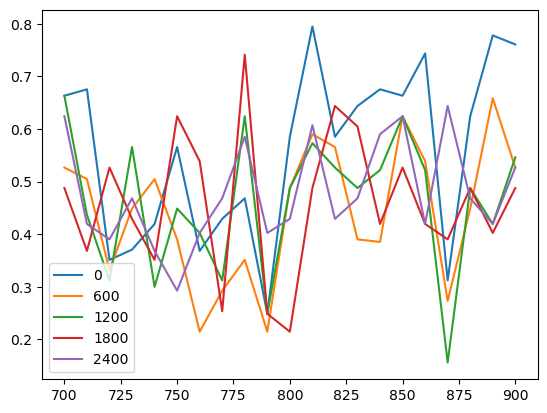

In [25]:
for i in range(0,2900,600):
    # plt.plot(np.linspace(750,850,21),spectras[:,i].cpu().numpy(),label=str(i))
    plt.plot(np.linspace(700,900,len(spectras.cpu())),spectras.cpu()[:,i],label=str(i))
plt.legend()

## Can we reconstruct FTS measurements with a semi learnable kernel?

In [35]:
# del model
model = FourierDenoiser(mask=mask,kernel=kernel,CoordGate=False,trainable_kernel=True, name='FTS_unet_trainkern')

model.load_state_dict(torch.load('../FTS_unet_trainkern',map_location='cpu')); #trained on all data.

model = model.to('cpu')
model.eval();
model.mask = model.mask.to('cpu')
model.kernel_learner.kernel = model.kernel_learner.kernel.to('cpu')

In [31]:
model.kernel_learner = model.kernel_learner.to('cpu')


In [37]:
x,y  = dataset[[600,1800]]
y_pred = model(x)


In [58]:
trained_kernel = model.kernel_learner.fill_kernel()
print(model.wiener_noise)

Parameter containing:
tensor([-0.0026], requires_grad=True)


In [44]:
pos = findclusters(kernel.cpu(),threshold=0.03, padding=150,type='boxes')

Text(0.5, 1.0, 'Trainable region')

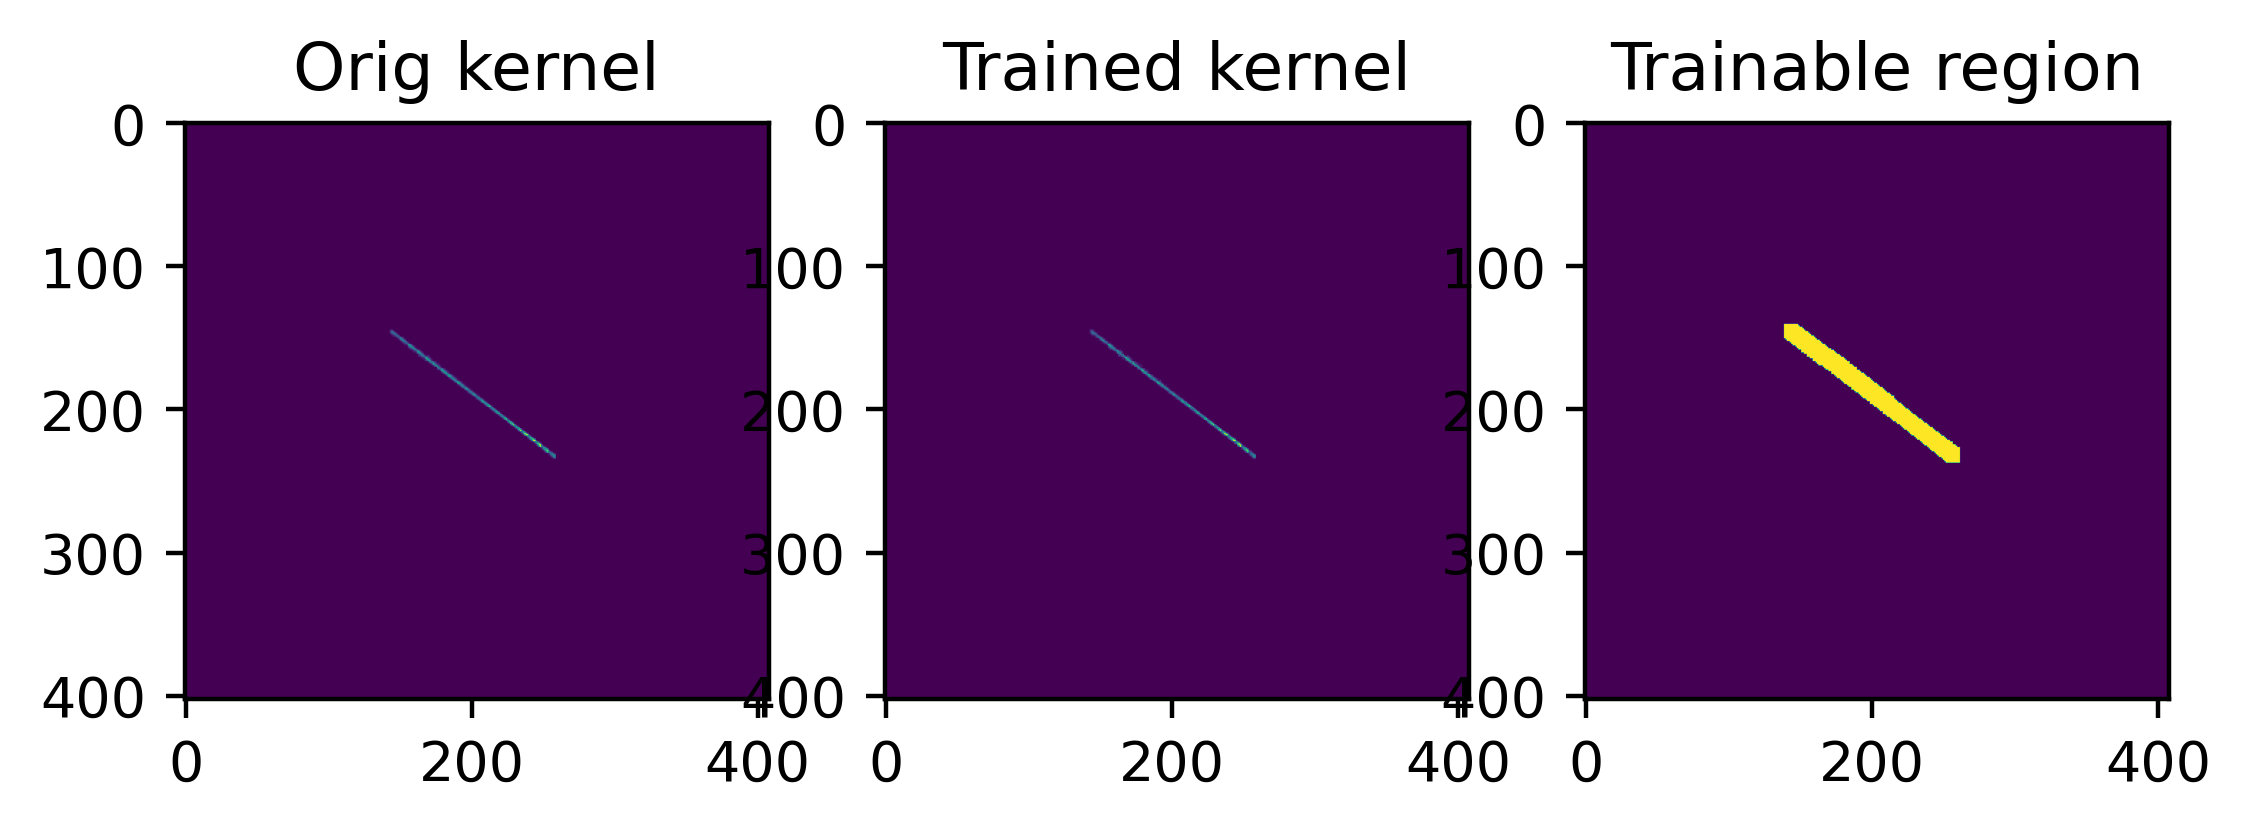

In [47]:
bx = pos[0,0]
by = pos[0,1]

fig,ax = plt.subplots(1,3,dpi=400)
ax[0].imshow(torch.sum(kernel[0],dim=0)[bx[0]:bx[1],by[0]:by[1]].cpu().detach().numpy()); ax[0].set_title('Orig kernel')
ax[1].imshow(torch.sum(trained_kernel[0],dim=0)[bx[0]:bx[1],by[0]:by[1]].cpu().detach().numpy()); ax[1].set_title('Trained kernel')
ax[2].imshow((torch.sum(model.kernel_learner.locations,axis=0)>0)[bx[0]:bx[1],by[0]:by[1]]); ax[2].set_title('Trainable region')

Text(0.5, 1.0, 'Trainable region')

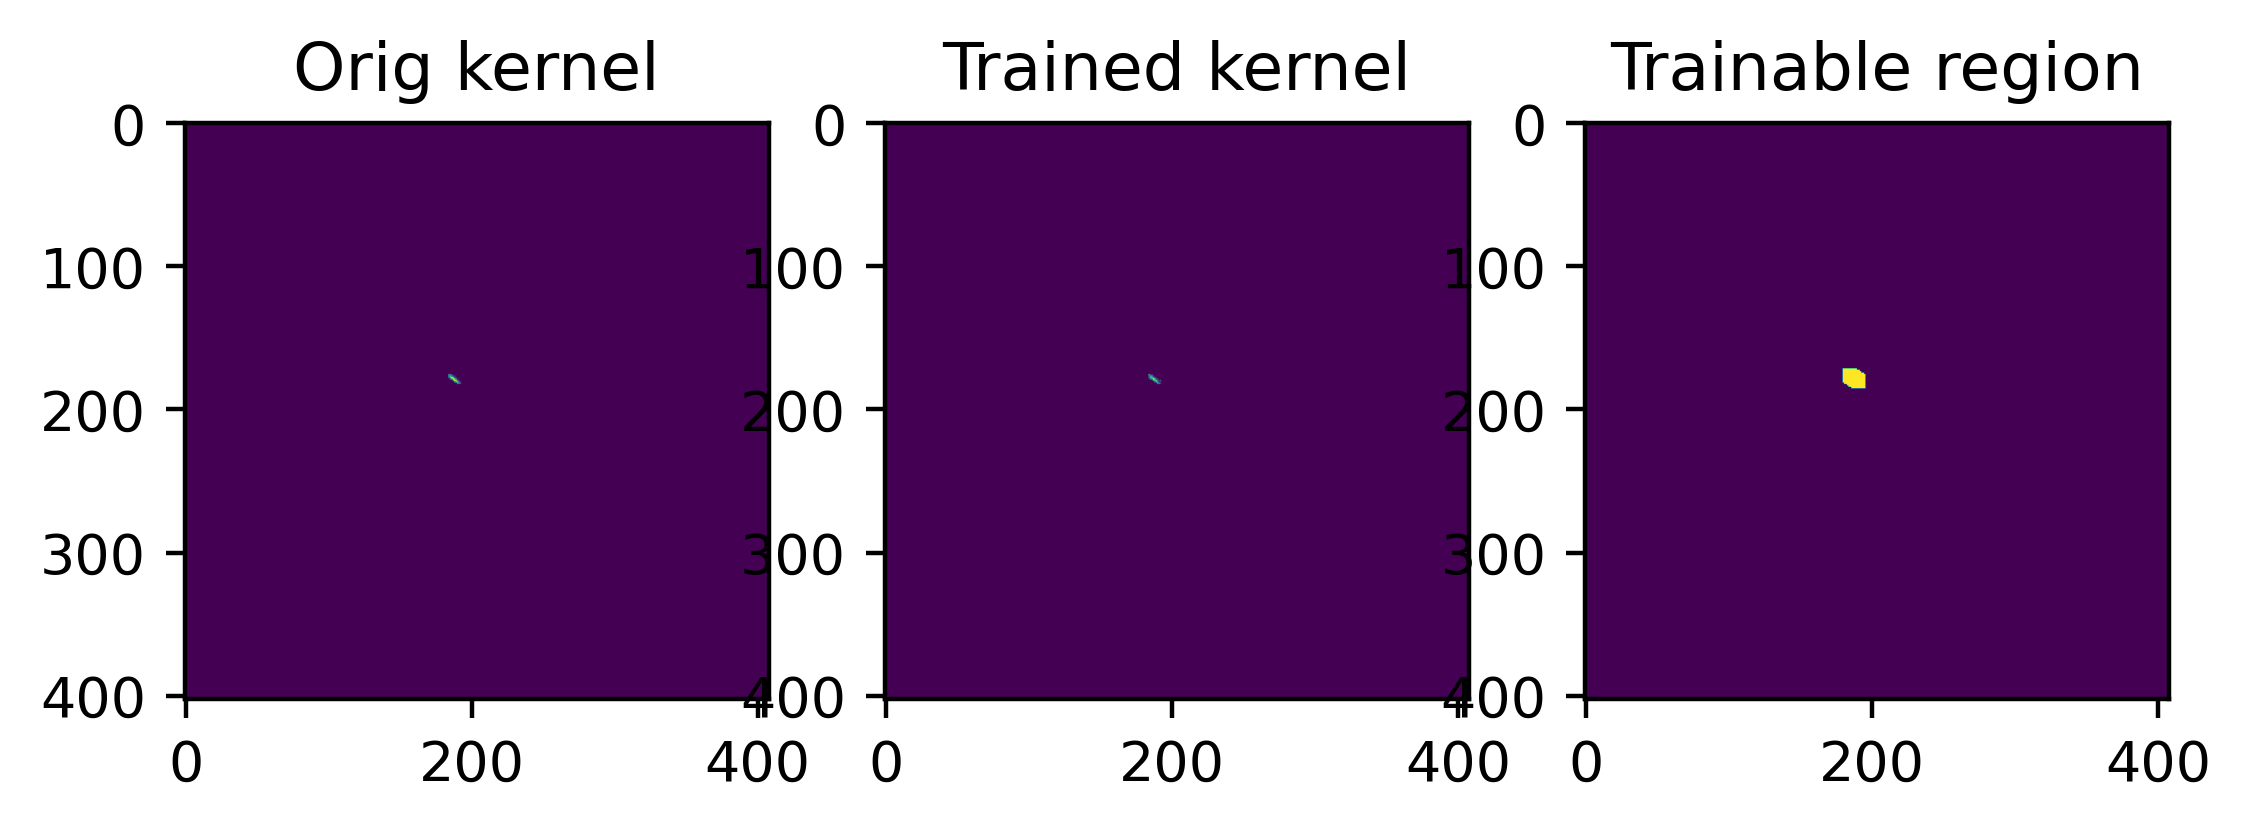

In [56]:
l  = 7

fig,ax = plt.subplots(1,3,dpi=400)
ax[0].imshow(kernel[0,l][bx[0]:bx[1],by[0]:by[1]].cpu().detach().numpy()); ax[0].set_title('Orig kernel')
ax[1].imshow(trained_kernel[0,l][bx[0]:bx[1],by[0]:by[1]].cpu().detach().numpy()); ax[1].set_title('Trained kernel')
ax[2].imshow((model.kernel_learner.locations[l]>0)[bx[0]:bx[1],by[0]:by[1]]); ax[2].set_title('Trainable region')

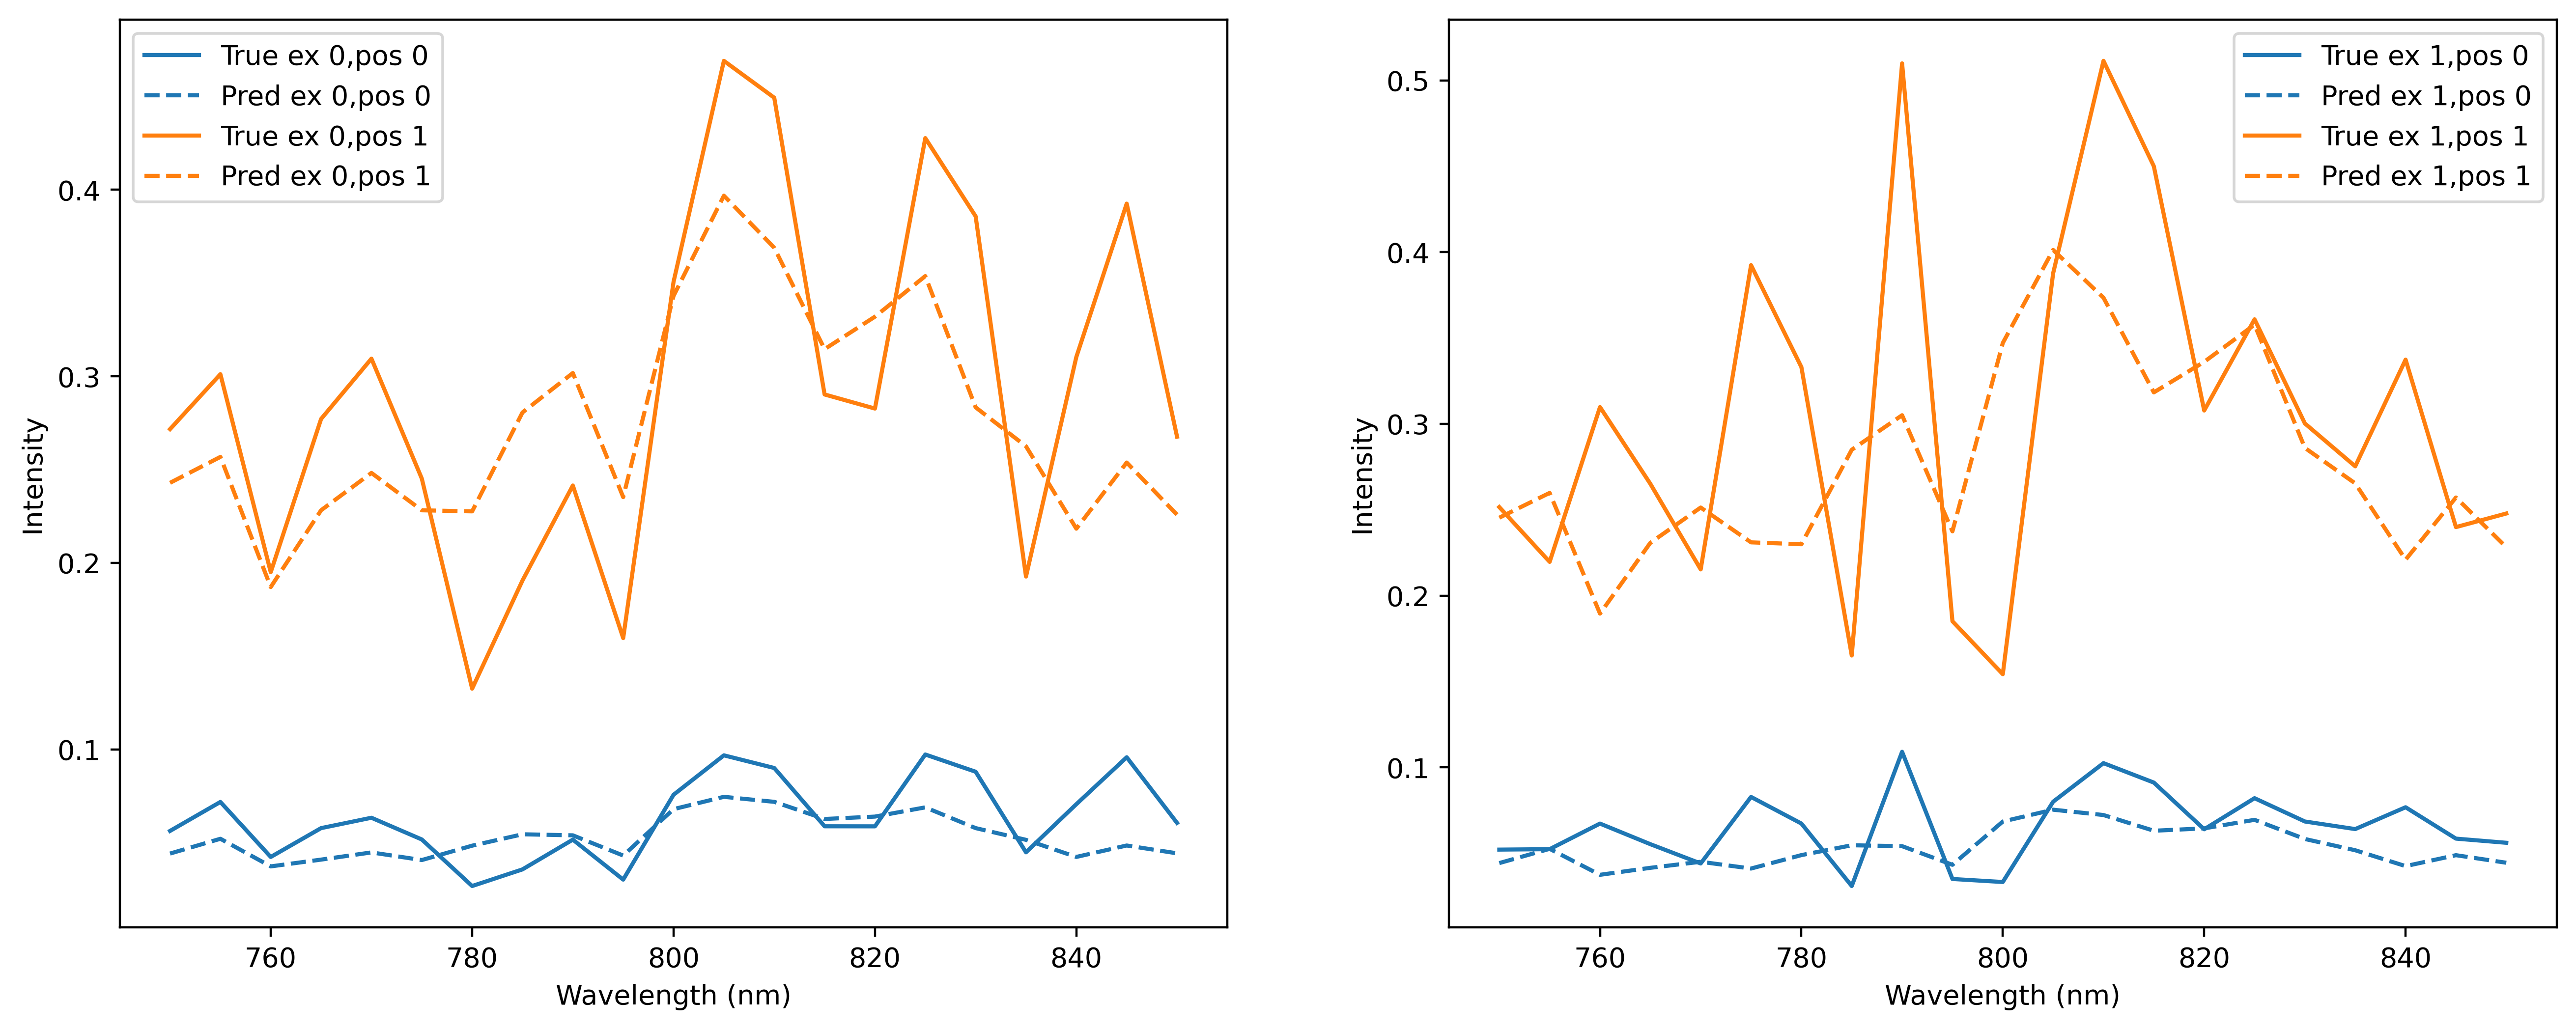

In [57]:
wls = np.linspace(750,850,21)


j=0

coords1 = [505,196]
boxsize = 5

coords2 = [293,302]
coords = [coords1,coords2]

fig,ax = plt.subplots(1,2,dpi=400,figsize=(16,6))

for j in range(2):
        
        for i in range(2):
                line, = ax[j].plot(wls,y[j,:,coords[i][0]+i,coords[i][1]].cpu().detach().numpy(),label=   f'True ex {j},pos {i}')
                ax[j].plot(wls,y_pred[j,:,coords[i][0]+i,coords[i][1]].cpu().detach().numpy(),color = line.get_color(),linestyle='--',label=   f'Pred ex {j},pos {i}')

        ax[j].set_xlabel('Wavelength (nm)')
        ax[j].set_ylabel('Intensity')
        ax[j].legend()
        


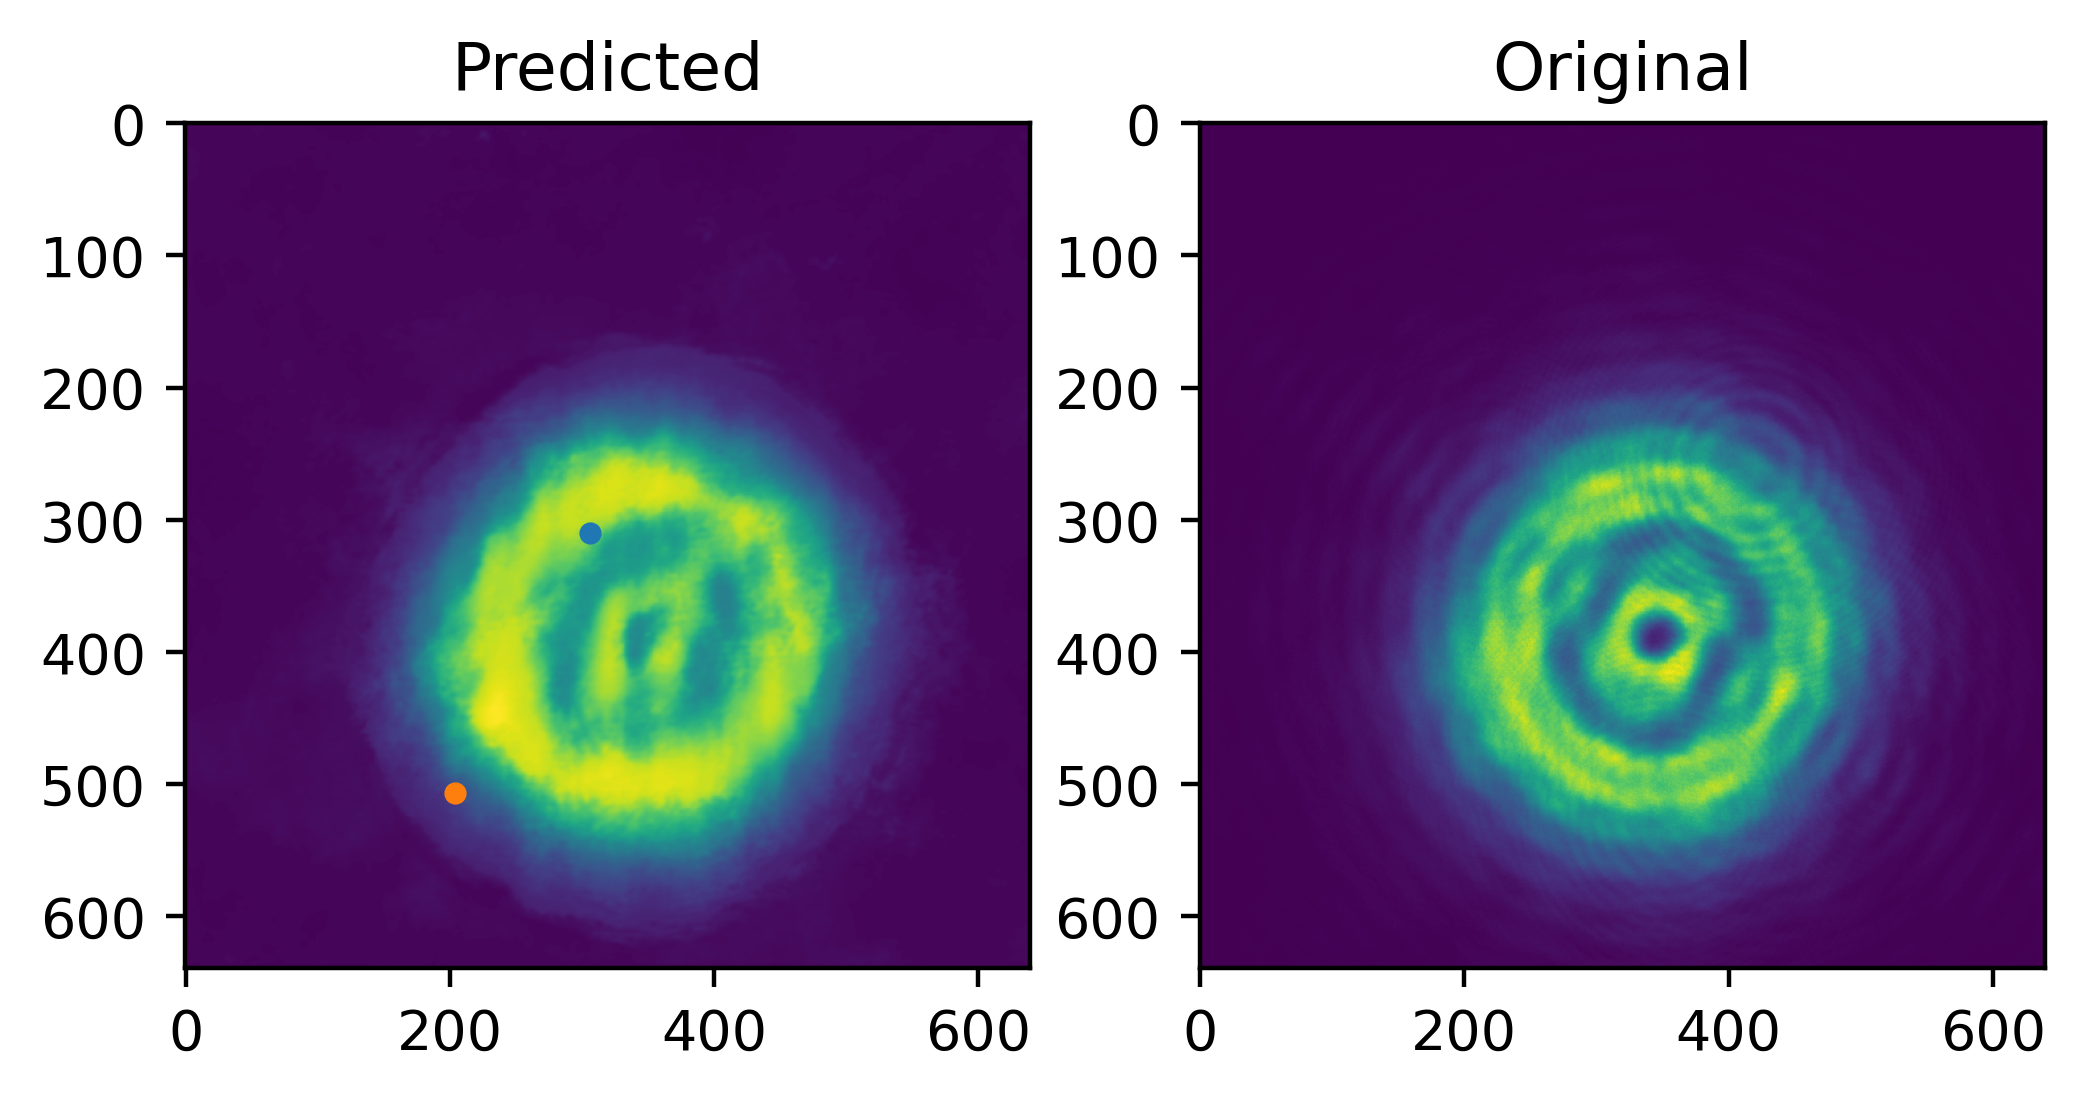

In [60]:
fig,ax = plt.subplots(1,2,figsize=(6,5),dpi=400)
ax[0].imshow(y_pred[0,10].cpu().detach().numpy()); ax[0].set_title('Predicted')
ax[1].imshow(y[0,10].cpu().detach().numpy())    ; ax[1].set_title('Original')

coords1 = [310,306]
boxsize = 5

coords2 = [507,204]

ax[0].plot(coords1[1],coords1[0],'.')

ax[0].plot(coords2[1],coords2[0],'.')

